# 0. Load and prepare data 

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Load csv file with pandas
df = pd.read_csv('data/diabetes.csv')

# drop all na values
df = df.dropna()


# X and y
X = df.drop('Outcome', axis=1).values  # shape: (n_samples, 8)
y = df['Outcome'].values.reshape(-1, 1)  # shape: (n_samples, 1)

# basic Scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(X_train.shape)  # (614, 8)
print(y_train.shape)  # (614, 1)

(614, 8)
(614, 1)


# 1. Own Implementation

In [65]:
# imports
import numpy as np
import pandas as pd
#from scipy.special import expit  # Sigmoid

In [ ]:
class NeuralNetwork:

    def __init__(self, input_size = 8, 
                 hidden1_size=100, 
                 hidden2_size = 50, 
                 output_size = 1, 
                 lr=0.1, 
                 activation_hidden='relu'):
        
        # activation function
        self.activation_hidden = activation_hidden

        # Learning rate
        self.lr = lr
        # Weights and biases
        # Input -> Hidden1
        self.w0 = np.random.randn(hidden1_size, input_size) * 0.01
        self.b0 = np.zeros((hidden1_size, 1))

        # # Hidden1 → hidden2
        self.w1 = np.random.randn(hidden2_size, hidden1_size) * 0.01
        self.b1 = np.zeros((hidden2_size, 1))

        # Hidden2 -> Output
        self.w2 = np.random.randn(output_size, hidden2_size) * 0.01
        self.b2 = np.zeros((output_size, 1))

        # Activation values
        self.a0 = None
        self.a1 = None
        self.a2 = None


    # Sigmoid for the output layer
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        #return expit(x)  # optional
    
    def sigmoid_deriv(self, a):
        return a * (1 - a) 

    # Activation function selector
    def activation(self, x):
        if self.activation_hidden == 'relu':
            return np.maximum(0, x)
        
        elif self.activation_hidden == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        
        elif self.activation_hidden == 'tanh':
            return np.tanh(x)
        
        else:
            raise ValueError("Unsupported activation function")

    # Activation derivative selector  
    def activation_deriv(self, a):
        if self.activation_hidden == 'relu':
            return (a > 0).astype(float)
        
        elif self.activation_hidden == 'sigmoid':
            return a * (1 - a) 
        
        elif self.activation_hidden == 'tanh':
             return 1 - a**2
        
        else:
            raise ValueError("Unsupported activation function")



    # Loss function
    # Binary Cross-Entropy 
    def loss(self, y_true, y_pred):
        epsilon = 1e-12  # avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) # if y_pred is < epsilon
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def loss_deriv(self, y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (y_pred - y_true) / (y_pred * (1 - y_pred))

    def forward(self, X):

        self.X = X.T # X.T: (input_size, m)

        ### 1. Hidden Layer
        # z0 = W0 @ X_T + b0 
        # a0 = sig(z0)
        self.a0 = self.activation(self.w0 @ X.T + self.b0)
        
        ### 2. hidden layer 
        # z1 = W1 @ a0 + b1
        # a1 = sig(z1)
        self.a1 = self.activation(self.w1 @ self.a0 + self.b1)

        # output Layer
        self.a2 = self.sigmoid(self.w2 @ self.a1 + self.b2)

        return self.a2


    # Backward pass
    def backward(self, X, y_true):

        Y = y_true.T      # (output_size, m)
        m = Y.shape[1]    # samples

        y_true = y_true.T 

        ### OUTPUT LAYER
        # delta2 = self.a1 - y_true.T # optional this simple calculation
        delta2 = self.loss_deriv(Y, self.a2) * self.sigmoid_deriv(self.a2)

        # Gradients for w2, b2: 
        dw2 = (delta2 @ self.a1.T) / m  
        db2 = np.sum(delta2, axis=1, keepdims=True) / m

        ### HIDDEN LAYER 2
        # (weights output layer x error output layer) * derived activation 
        delta1 = (self.w2.T @ delta2) * self.activation_deriv(self.a1)

        # Gradients for w1, b1:
        # dw1: error in hidden layer 1 * outputs from hiddenlayer 2 (a2)
        dw1 = delta1 @ self.a0.T / m
        db1 = np.sum(delta1, axis=1, keepdims=True) / m # sum errors in current layer

        ### HIDDEN LAYER 1
        # Error back to the previous layer 
        delta0 = (self.w1.T @ delta1) * self.activation_deriv(self.a0)

        # Gradients for w0, b0: 
        dw0 = (delta0 @ self.X.T) / m 
        db0 = np.sum(delta0, axis=1, keepdims=True) / m

        # Update
        self.w2 -= self.lr * dw2
        self.b2 -= self.lr * db2
        self.w1 -= self.lr * dw1
        self.b1 -= self.lr * db1
        self.w0 -= self.lr * dw0
        self.b0 -= self.lr * db0


    def train(self, X, y):
        # Get the prediciton for current wheights
        y_pred = self.forward(X)

        # Compute the loss 
        current_loss = self.loss(y.T, y_pred)

        # Update the weights and biases
        self.backward(X, y)
        return current_loss


    def predict(self, X):
        a1 = self.forward(X)
        return a1.T


### Train the Network 


=== Training Model 1/4 ===
Parameters: {'input_size': 8, 'hidden1_size': 16, 'hidden2_size': 8, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu'}
Epoch 0: Loss = 0.693147
Epoch 1000: Loss = 0.645927
Epoch 2000: Loss = 0.645508
Epoch 3000: Loss = 0.645501
Epoch 4000: Loss = 0.645498
Epoch 5000: Loss = 0.645494
Epoch 6000: Loss = 0.645489
Epoch 7000: Loss = 0.645481
Epoch 8000: Loss = 0.645469
Epoch 9000: Loss = 0.645451
Epoch 10000: Loss = 0.645420
Epoch 11000: Loss = 0.645361
Epoch 12000: Loss = 0.645246
Epoch 13000: Loss = 0.644980
Epoch 14000: Loss = 0.644233
Epoch 15000: Loss = 0.641381
Epoch 16000: Loss = 0.623149
Epoch 17000: Loss = 0.499210
Epoch 18000: Loss = 0.453054
Epoch 19000: Loss = 0.444572
Epoch 20000: Loss = 0.440675
Epoch 21000: Loss = 0.437622
Epoch 22000: Loss = 0.434585
Epoch 23000: Loss = 0.430136
Epoch 24000: Loss = 0.426914
Epoch 25000: Loss = 0.424602
Epoch 26000: Loss = 0.422241
Epoch 27000: Loss = 0.420171
Epoch 28000: Loss = 0.418270
Epoch 29000: Los

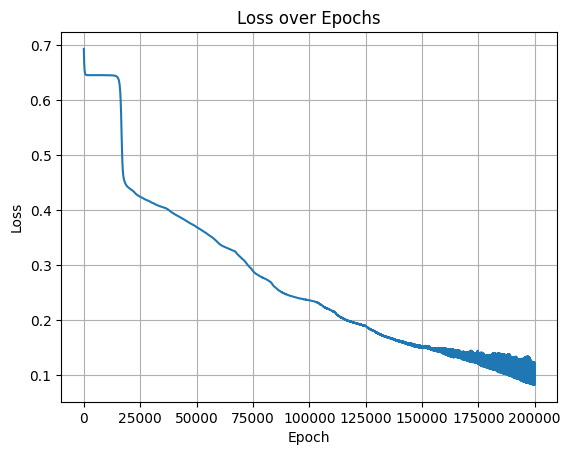


Minimum loss: 0.082765

=== Training Model 2/4 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.001, 'activation_hidden': 'relu'}
Epoch 0: Loss = 0.693144
Epoch 1000: Loss = 0.674682
Epoch 2000: Loss = 0.663463
Epoch 3000: Loss = 0.656613
Epoch 4000: Loss = 0.652408
Epoch 5000: Loss = 0.649812
Epoch 6000: Loss = 0.648201
Epoch 7000: Loss = 0.647197
Epoch 8000: Loss = 0.646569
Epoch 9000: Loss = 0.646175
Epoch 10000: Loss = 0.645928
Epoch 11000: Loss = 0.645771
Epoch 12000: Loss = 0.645673
Epoch 13000: Loss = 0.645610
Epoch 14000: Loss = 0.645570
Epoch 15000: Loss = 0.645545
Epoch 16000: Loss = 0.645529
Epoch 17000: Loss = 0.645518
Epoch 18000: Loss = 0.645511
Epoch 19000: Loss = 0.645507
Epoch 20000: Loss = 0.645504
Epoch 21000: Loss = 0.645502
Epoch 22000: Loss = 0.645500
Epoch 23000: Loss = 0.645499
Epoch 24000: Loss = 0.645498

Stopped after epoch 24412. No improvement for 5000 epochs.


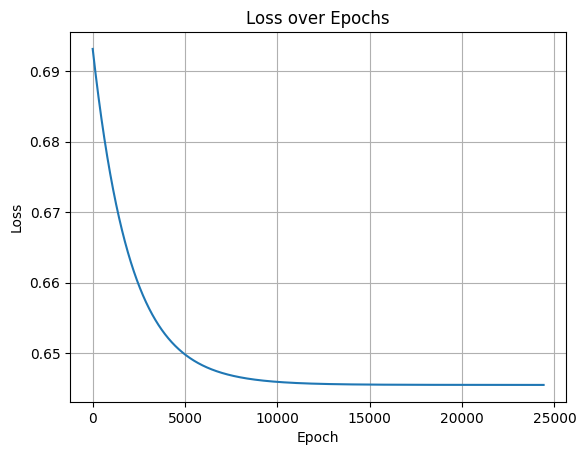


Minimum loss: 0.645498

=== Training Model 3/4 ===
Parameters: {'input_size': 8, 'hidden1_size': 16, 'hidden2_size': 8, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'sigmoid'}
Epoch 0: Loss = 0.687835
Epoch 1000: Loss = 0.645509
Epoch 2000: Loss = 0.645507
Epoch 3000: Loss = 0.645506
Epoch 4000: Loss = 0.645504
Epoch 5000: Loss = 0.645502
Epoch 6000: Loss = 0.645501
Epoch 7000: Loss = 0.645499
Epoch 8000: Loss = 0.645496
Epoch 9000: Loss = 0.645494
Epoch 10000: Loss = 0.645492
Epoch 11000: Loss = 0.645489
Epoch 12000: Loss = 0.645485
Epoch 13000: Loss = 0.645482
Epoch 14000: Loss = 0.645478
Epoch 15000: Loss = 0.645473
Epoch 16000: Loss = 0.645468
Epoch 17000: Loss = 0.645462
Epoch 18000: Loss = 0.645455
Epoch 19000: Loss = 0.645448
Epoch 20000: Loss = 0.645439
Epoch 21000: Loss = 0.645429
Epoch 22000: Loss = 0.645418
Epoch 23000: Loss = 0.645405
Epoch 24000: Loss = 0.645391
Epoch 25000: Loss = 0.645374
Epoch 26000: Loss = 0.645354
Epoch 27000: Loss = 0.645332
Epoch 28000: Loss 

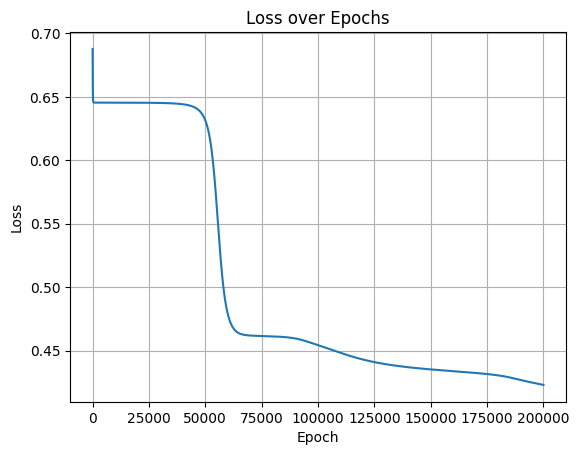


Minimum loss: 0.422917

=== Training Model 4/4 ===
Parameters: {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'relu'}
Epoch 0: Loss = 0.693146
Epoch 1000: Loss = 0.649787
Epoch 2000: Loss = 0.645903
Epoch 3000: Loss = 0.645515
Epoch 4000: Loss = 0.645464
Epoch 5000: Loss = 0.645443
Epoch 6000: Loss = 0.645422
Epoch 7000: Loss = 0.645394
Epoch 8000: Loss = 0.645355
Epoch 9000: Loss = 0.645300
Epoch 10000: Loss = 0.645221
Epoch 11000: Loss = 0.645101
Epoch 12000: Loss = 0.644912
Epoch 13000: Loss = 0.644597
Epoch 14000: Loss = 0.644037
Epoch 15000: Loss = 0.642960
Epoch 16000: Loss = 0.640665
Epoch 17000: Loss = 0.635084
Epoch 18000: Loss = 0.619321
Epoch 19000: Loss = 0.573095
Epoch 20000: Loss = 0.496651
Epoch 21000: Loss = 0.461564
Epoch 22000: Loss = 0.451922
Epoch 23000: Loss = 0.447083
Epoch 24000: Loss = 0.443842
Epoch 25000: Loss = 0.441623
Epoch 26000: Loss = 0.439888
Epoch 27000: Loss = 0.438196
Epoch 28000: Loss =

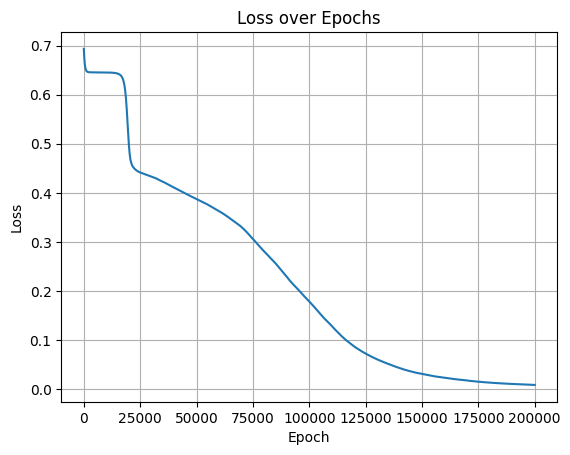


Minimum loss: 0.008982


In [92]:
import matplotlib.pyplot as plt

def train_model(model_params, X_train, y_train, 
                max_epochs=100000, 
                tolerance=1e-5, 
                patience=10000, 
                print_every=1000):
    
    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden']
    )
    
    losses = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        if print_every and epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f}")

        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot (optional)
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    return losses



parameter_grid = [
    {'input_size': 8, 'hidden1_size': 16, 'hidden2_size': 8,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu'},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.001, 'activation_hidden': 'relu'},
    {'input_size': 8, 'hidden1_size': 16, 'hidden2_size': 8,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'sigmoid'},
    {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'relu'},
]


results = []

for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")

    # print parameters 
    print(f"Parameters: {params}")

    losses = train_model(params, X_train, y_train, max_epochs=200000, patience=5000, print_every=1000)
    
    results.append({
        'params': params,
        'min_loss': min(losses)
    })


Epoch 0: Loss = 0.6931
Epoch 1000: Loss = 0.6459
Epoch 2000: Loss = 0.6455
Epoch 3000: Loss = 0.6455
Epoch 4000: Loss = 0.6455
Epoch 5000: Loss = 0.6455
Epoch 6000: Loss = 0.6455
Epoch 7000: Loss = 0.6455
Epoch 8000: Loss = 0.6455
Epoch 9000: Loss = 0.6455
Epoch 10000: Loss = 0.6455
Epoch 11000: Loss = 0.6455
Epoch 12000: Loss = 0.6455
Epoch 13000: Loss = 0.6455
Epoch 14000: Loss = 0.6454
Epoch 15000: Loss = 0.6454
Epoch 16000: Loss = 0.6453
Epoch 17000: Loss = 0.6452
Epoch 18000: Loss = 0.6448
Epoch 19000: Loss = 0.6435
Epoch 20000: Loss = 0.6375
Epoch 21000: Loss = 0.5870
Epoch 22000: Loss = 0.4754
Epoch 23000: Loss = 0.4520
Epoch 24000: Loss = 0.4455
Epoch 25000: Loss = 0.4419
Epoch 26000: Loss = 0.4384
Epoch 27000: Loss = 0.4337
Epoch 28000: Loss = 0.4295
Epoch 29000: Loss = 0.4250
Epoch 30000: Loss = 0.4199
Epoch 31000: Loss = 0.4143
Epoch 32000: Loss = 0.4102
Epoch 33000: Loss = 0.4074
Epoch 34000: Loss = 0.4051
Epoch 35000: Loss = 0.4034
Epoch 36000: Loss = 0.4018
Epoch 37000: L

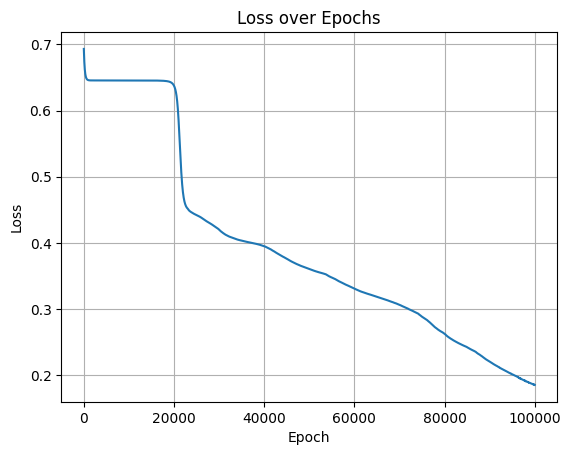

np.float64(0.18527488701841988)

In [89]:
model = NeuralNetwork(input_size=8, hidden1_size=16, hidden2_size=8, output_size=1, lr=0.01, 
                      activation_hidden='relu')


losses = []
tolerance = 1e-5   
patience = 10000             
best_loss = float('inf')  
no_improvement = 0      

max_epochs = 100000 #

for epoch in range(max_epochs):
    loss = model.train(X_train, y_train)
    losses.append(loss)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

    # 
    if best_loss - loss > tolerance:
        best_loss = loss
        no_improvement = 0
    else:
        no_improvement += 1

    # 
    if no_improvement >= patience:
        print(f"\n Stop after erpch: {epoch}. no decresment after {patience} epochs")
        break


plt.plot(losses)
plt.xlabel("Epoch")

plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
plt.show()

min(losses)

In [ ]:
max(losses)


Accuracy: 0.6948


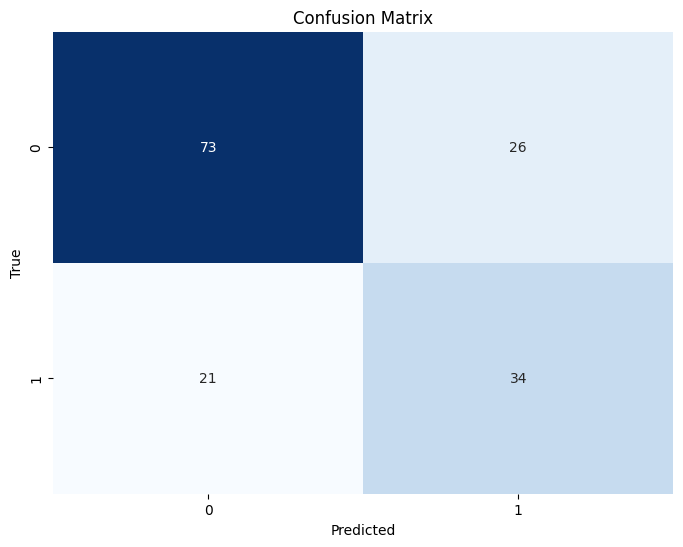

Confusion Matrix:
[[73 26]
 [21 34]]
Mean y_pred: 0.391073419345021


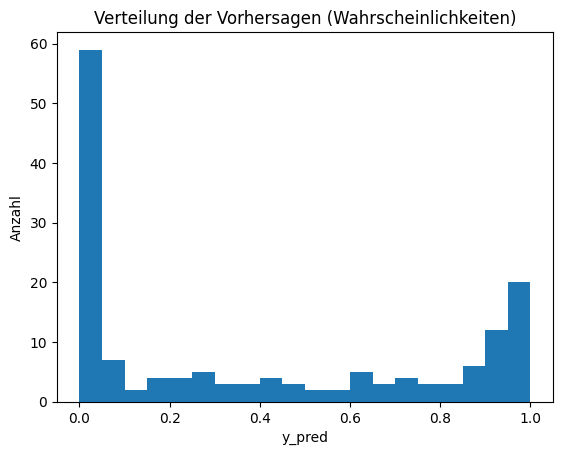

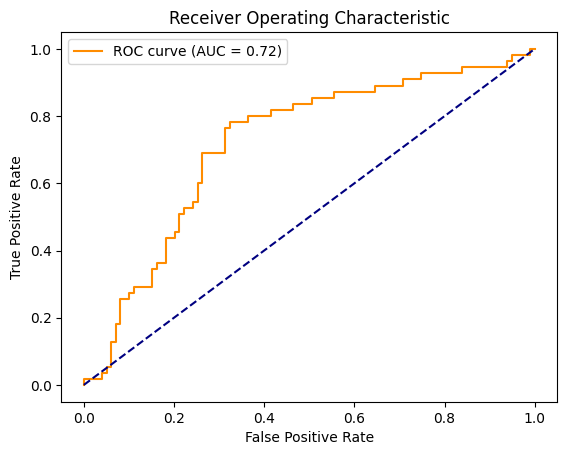

In [86]:
# Predict 
y_pred = model.predict(X_test)
# Convert predictions to binary with a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)
y_test_binary = y_test.astype(int)


# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_test_binary)
print(f"Accuracy: {accuracy:.4f}")

# confussion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# print confusion matrix
print("Confusion Matrix:")
print(cm)

print("Mean y_pred:", np.mean(y_pred))


import matplotlib.pyplot as plt
plt.hist(y_pred, bins=20)
plt.title("Verteilung der Vorhersagen (Wahrscheinlichkeiten)")
plt.xlabel("y_pred")
plt.ylabel("Anzahl")
plt.show()


from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


## Model stats 

In [6]:
from pympler import asizeof

def get_model_stats(model):
    import numpy as np

 
    arrays = [model.w0, model.b0, model.w1, model.b1, model.w2, model.b2]
    
    # number of paramters (all weights + biases)
    total_params = sum(arr.size for arr in arrays)

    # RAM
    size_bytes = asizeof.asizeof(model)
    # bytes into MB
    total_MB = size_bytes / (1024 ** 2)

    print(f"Total learnable parameters: {total_params:,}")
    print(f"Total size in RAM: {total_MB:.2f} MB")

    return total_params, total_MB


get_model_stats(model)

Total learnable parameters: 6,001
Total size in RAM: 0.24 MB


(6001, 0.24430084228515625)

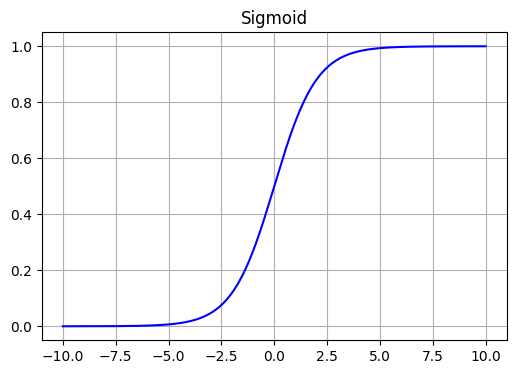

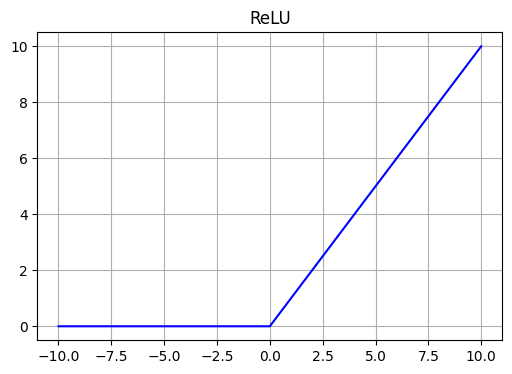

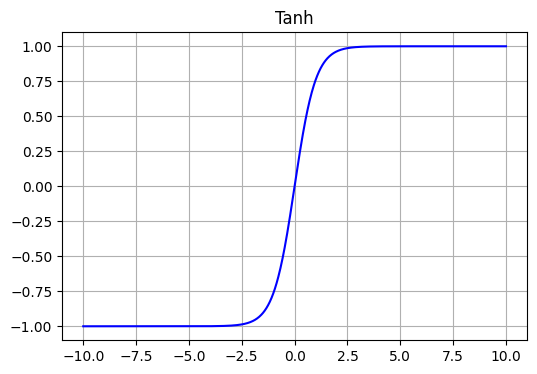

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

# Wertebereich
x = np.linspace(-10, 10, 1000)

# Auswerten der Funktionen
sig = sigmoid(x)

r = relu(x)

t = tanh(x)


# Einzelne Plots generieren
def plot_function(x, y, title, color='blue'):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, color=color)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plotten
plot_function(x, sig, 'Sigmoid')

plot_function(x, r, 'ReLU')

plot_function(x, t, 'Tanh')


# 2. PyTorch 

**Sequential Model:**

https://medium.com/writeasilearn/using-sequential-module-to-build-a-neural-network-a34ca3f37203


In [8]:
# Data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import torch

# Features: float32
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)

# Targets: float32 UND als Spaltenvektor (N, 1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim


model = nn.Sequential(
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

# binary cross-entropy loss
criterion = nn.BCELoss() 

# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.01)
lr = 0.1

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()

    # Forward-Pass
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    # Zero gradients because PyTorch accumulates gradients
    model.zero_grad()

    # Backward-Pass (clac gradients)
    loss.backward()

    # Update manuelly
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad

    # print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6855
Epoch 100, Loss: 0.4597
Epoch 200, Loss: 0.4314
Epoch 300, Loss: 0.4159
Epoch 400, Loss: 0.4031
Epoch 500, Loss: 0.3918
Epoch 600, Loss: 0.3814
Epoch 700, Loss: 0.3711
Epoch 800, Loss: 0.3601
Epoch 900, Loss: 0.3491


Test Accuracy: 0.7273


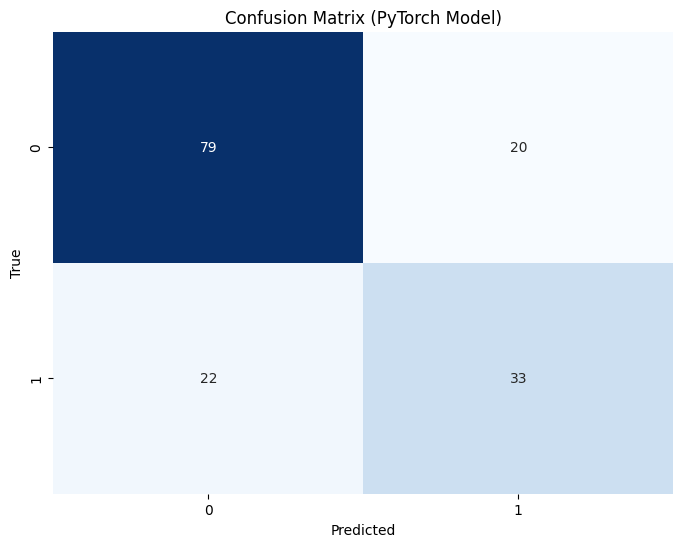

In [10]:
# Predict on test 
outputs_test = model(X_test_torch)
# Convert predictions to binary with a threshold of 0.5
y_pred_test = (outputs_test >= 0.5).float()
# Calculate accuracy
accuracy_test = (y_pred_test == y_test_torch).float().mean()
print(f"Test Accuracy: {accuracy_test:.4f}")
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test_torch.numpy(), y_pred_test.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (PyTorch Model)')
plt.show()


# 3. LLM Implementation


Prompt: 
Implement a framework for neural networks (NN). Implement the entire network from scratch, including forward and backward propagation methods

In [83]:
import numpy as np

# Base class for layers
class Layer:
    def forward(self, input):
        raise NotImplementedError
        
    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

# Dense (fully connected) layer
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.bias = np.zeros((1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.mean(output_gradient, axis=0, keepdims=True)
        return input_gradient

# Activation functions
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return self.activation_prime(self.input) * output_gradient

# Specific activation functions
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

# Loss function
class MeanSquaredError:
    def loss(self, predicted, actual):
        return np.mean(np.power(predicted - actual, 2))

    def gradient(self, predicted, actual):
        return 2 * (predicted - actual) / actual.size

# Neural network class
class NeuralNetwork2:
    def __init__(self):
        self.layers = []
        self.loss_fn = MeanSquaredError()

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.predict(x_train)
            loss = self.loss_fn.loss(output, y_train)
            grad = self.loss_fn.gradient(output, y_train)
            
            for layer in reversed(self.layers):
                grad = layer.backward(grad, learning_rate)
            
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.2930
Epoch 100, Loss: 0.2377
Epoch 200, Loss: 0.2151
Epoch 300, Loss: 0.1953
Epoch 400, Loss: 0.1844
Epoch 500, Loss: 0.1796
Epoch 600, Loss: 0.1758
Epoch 700, Loss: 0.1720
Epoch 800, Loss: 0.1691
Epoch 900, Loss: 0.1671
Epoch 1000, Loss: 0.1654
Accuracy: 0.7150


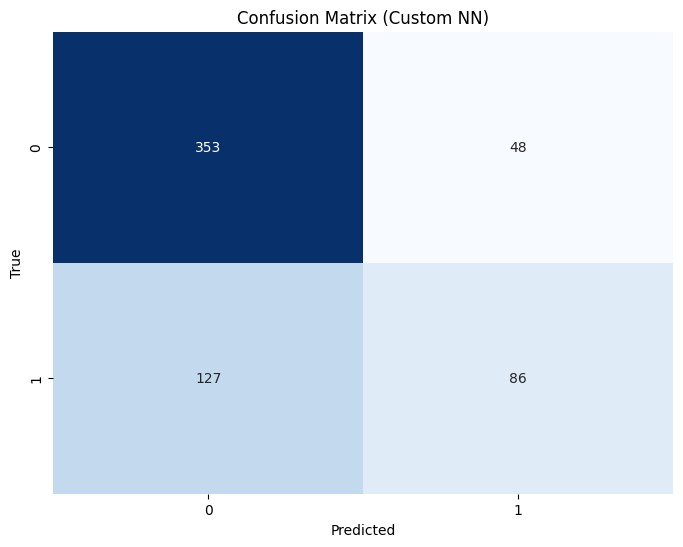

In [84]:
nn = NeuralNetwork2()
nn.add(Dense(8, 4))
nn.add(Activation(relu, relu_prime))
nn.add(Dense(4, 1))
nn.add(Activation(sigmoid, sigmoid_prime))


nn.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Predictions
preds = nn.predict(X_train)
pred_classes = (preds >= 0.5).astype(int)

true_classes = y_train.reshape(-1, 1)

# Accuracy 
accuracy = np.mean(pred_classes == true_classes)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_nn = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Custom NN)')
plt.show()

